In [3]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Include all the parquet files for ZJetsToNuNu
/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/ZJetsToNuNu_HT-*


For loop probably needed. Then run NN.
Combine ttbar and ZJetsToNuNu? Compare separate too.

In [4]:
signal_data = pd.read_parquet('/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/ttH_HToInvisible_M125.parquet')

#the background we use here  is ZJetsToNuNu_HT-*.parquet
base_dir = '/dice/projects/CMS/Hinv/ml_datasets_ul_241111/ml_inputs_UL2018/'
file_names = ['ZJetsToNuNu_HT-100To200.parquet',
    'ZJetsToNuNu_HT-200To400.parquet',
    'ZJetsToNuNu_HT-400To600.parquet',
    'ZJetsToNuNu_HT-600To800.parquet',
    'ZJetsToNuNu_HT-800To1200.parquet',
    'ZJetsToNuNu_HT-1200To2500.parquet',
    'ZJetsToNuNu_HT-800To1200.parquet',
    'ZJetsToNuNu_HT-2500ToInf.parquet'
]

BG_uncombined = [pd.read_parquet(os.path.join(base_dir, file)) for file in file_names]
background_data = pd.concat(BG_uncombined, ignore_index=True)


In [5]:
signal_data.columns

Index(['event', 'region', 'Generator_weight', 'Generator_scalePDF',
       'Generator_x1', 'Generator_x2', 'Generator_xpdf1', 'Generator_xpdf2',
       'cleanedJet_pt', 'cleanedJet_eta', 'cleanedJet_phi', 'cleanedJet_mass',
       'cleanedJet_area', 'cleanedJet_btagDeepFlavB', 'GenMET_pt',
       'GenMET_phi', 'InputMet_pt', 'InputMet_phi', 'ncleanedJet',
       'ncleanedBJet', 'HT', 'MHT_pt', 'MHT_phi', 'InputMet_InputJet_mindPhi',
       'weight_nominal', 'xs_weight', 'Pred', 'cleanedJet_pt_jesAbsolute_up',
       'cleanedJet_pt_jesAbsolute_down', 'cleanedJet_pt_jesBBEC1_up',
       'cleanedJet_pt_jesBBEC1_down', 'cleanedJet_pt_jesEC2_up',
       'cleanedJet_pt_jesEC2_down', 'cleanedJet_pt_jesFlavorQCD_up',
       'cleanedJet_pt_jesFlavorQCD_down', 'cleanedJet_pt_jesHF_up',
       'cleanedJet_pt_jesHF_down', 'cleanedJet_pt_jesRelativeBal_up',
       'cleanedJet_pt_jesRelativeBal_down',
       'cleanedJet_pt_jesAbsolute_2018_up',
       'cleanedJet_pt_jesAbsolute_2018_down', 'cleanedJ

In [6]:
#data preperation

def prep(signal_data, background_data):

    #remove NaN values
    signal_data = signal_data.dropna()
    background_data = background_data.dropna()

    #remove unsuitable regions in the regions column (want only 0 and 6+)
    regions_to_exclude = [1,2,3,4,5]
    signal_data = signal_data[~signal_data.region.isin(regions_to_exclude)]
    background_data = background_data[~background_data.region.isin(regions_to_exclude)]
    
    signal_data['weight_balance'] = len(background_data) / len(signal_data)
    background_data['weight_balance'] = 1

    signal_data['target'] = 1
    background_data['target'] = 0

    #combine sign & BG datasets
    data = pd.concat([signal_data, background_data])

    return data

data = prep(signal_data, background_data)


In [7]:
# Define features and scale them
features = [
    'HT', 'InputMet_phi', 'InputMet_pt', 'MHT_phi', 'MHT_pt', 
    'ncleanedBJet', 'ncleanedJet',
    'region'
]

#scales features to have a mean = 0  and std = 1 (makes training more stable & efficient).
scaler = StandardScaler()
#Fit the scalar to selected features in data & transform them in place, overwriting opriginal values witht he SCALED ones
data[features] = scaler.fit_transform(data[features])



#we need to scale as some features varyb widely in magnitude which can hinder training.
#NN's are sensitive to the scale of the input data. Scaling ensures all features contribute proportionally to the models training process.


In [8]:
# Convert data to PyTorch tensors

#Convert features to tensors(x). X is a tensor containing values of selected features from data[features].values
X = torch.tensor(data[features].values, dtype=torch.float32)

# Convert target to tensors(y). y is a tensor of target labels, indicating whether sample is sig (1) or BG (0).as_integer_ratio
# #.view(-1,1) reshapes y into column vector for binary classification.
y = torch.tensor(data['target'].values, dtype=torch.float32).view(-1, 1)

#converting weights to tensors. Used later in training loop to handle class imbalance
weights_nominal = torch.tensor(data['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(data['weight_balance'].values, dtype=torch.float32)


In [9]:
# Split data into train, validation, and test sets.
#80/20 train/test split. Outputs represent features labels, nominal weights & balance weights for both..
#.. training & validation set and test set.
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(
    X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42
)
#each x_train val is paired with y_train_val, wn_train_val, wb_train_val. (X_train_val, y_train_val, wn_train_val, wb_train_val)
#each x_test is paired with y_test, wn_test, wb_test. (X_test, y_test, wn_test, wb_test)
# ... allows us to keep track of weights. 

#this splits the training+validation set into   (64%) and validation (16%). These numbers come from 0.8*0.8=0.64, 0.8*0.2=0.16. 
#1st split is training+validation vs test. Second split only on the training+validation. 80% training, 20% validation.
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val = train_test_split(
    X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42
)


#Training set trains model. (Xtrain,yt_train,wn_train,wb_train)
#Validation set evaluates models performance during trainign & adjusts hyperparameters if needed. (X_val,y_val,wn_val,wb_val
#Test set is set aside until end of training to evaluate the model's generalisation ability on completely unseen data. (xtets,ytest,wntest,wbtest)


In [10]:
# Create DataLoaders

#(#Look at gradient descent mini batch)

#DataLoader is a PyTorch class that loads data in batches.
#train_loader loads training data in batches of 64 samples. shuffle=True shuffles the data before each epoch.
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=64, shuffle=True)

#val_loader loads validation data in batches of 64 samples. shuffle=False as we don't want to shuffle validation data.
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=64, shuffle=False)

#test_loader loads test data in batches of 64 samples. shuffle=False as we don't want to shuffle test data.
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=64, shuffle=False)

#shuffle is set to True for training data, as we want to shuffle the data before each epoch to prevent the model from learning the order of the data.

In [ ]:
def plot_inputs_per_multiplicity(inputs, labels, mask, bins, weights=None, log=False, outdir=None, show=False):
    n_parts = inputs.size(1)
    n_vars = inputs.size(2)

    fig, axs = plt.subplots(ncols=n_vars + 1, figsize=(4*(n_vars + 1), 3))
    plt.subplots_adjust(left=0.1, right=0.9, wspace=0.5)

    colors = plt.cm.rainbow(np.linspace(0, 1, n_parts))
    for i in range(n_vars):
        bins_var = np.linspace(inputs[..., i].min(), inputs[..., i].max(), bins)
        for j in range(n_parts):
            # Ensure mask is boolean and properly shaped
            current_mask = mask[:, j]
            if current_mask.ndim != 1 or current_mask.shape[0] != inputs.shape[0]:
                raise ValueError(f"Mask shape {current_mask.shape} is incompatible with inputs shape {inputs.shape}")
            
            axs[i].hist(
                inputs[:, j, i][current_mask],
                bins=bins_var,
                histtype='step',
                color=colors[j],
                weights=weights[current_mask] if weights is not None else None,
            )
        axs[i].set_xlabel(f'var {i}')
        if log:
            axs[i].set_yscale('log')
    for j in range(n_parts):
        axs[-1].hist([], color=colors[j], label=f'Jet #{j}')
    axs[-1].legend(loc="center left")
    axs[-1].axis("off")
    if outdir is not None:
        plt.savefig(f"{outdir}/inputs_per_njet.png", dpi=300)
    if show:
        plt.show()
    return fig

fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

In [11]:
#Defining NN model & initialising loss function & optimiser

#nn.Module is a base class for all NN models in PyTorch. Represents a simple feedforward..
#.. NN with customisable layers & neurons, disigned for binary classification.

class SimpleNN(nn.Module):
    # n_layers is the no. of HIDDEN LAYERS and n_neurons is the no. of neurons in each HIDDEN layer.
    def __init__(self, n_layers=3, n_neurons=32):
        #super() is a method that returns a proxy object that delegates method calls to a parent or sibling class of type.
        #Here, super(SimpleNN, self).__init__() initialises the base class (nn.Module) for the SimpleNN class.
        super(SimpleNN, self).__init__()
        #layers ia a listy that temporatily holds each layer of the model as it is created.
        #this allows us to construct the NN architecture in a loop, rather than writing each layer out individually.
        layers = [nn.Linear(len(features), n_neurons), nn.BatchNorm1d(n_neurons)]
        
        #for loop that creates n_layers-1 hidden layers, each with n_neurons neurons.
        for _ in range(n_layers - 1):
            layers += [nn.Linear(n_neurons, n_neurons), nn.BatchNorm1d(n_neurons)]
        #adds the output layer to the model. This is a single neuron, as we are performing binary classification.
        layers.append(nn.Linear(n_neurons, 1))
        #nn.ModuleList(layers) converts the list of layers into a PyTorch ModuleList, which is a container for Module objects.
        self.layers = nn.ModuleList(layers)

    #the forward method defines the forward pass of the NN. It takes an input tensor x and passes it through each layer of the model.
    def forward(self, x):
        for layer in self.layers[:-1]:
            #applies the ReLU activation function to the output of each hidden layer to introduce non-linearity.
            x = torch.relu(layer(x))
        
        #return self.layers[-1](x) applies the output layer to the final hidden layer output, returning the final model output.
        return self.layers[-1](x)
        #x is not a value between 0 and 1, but a value between -inf and inf. This is because the output layer is a single neuron with no activation function.
        #x is a logit
model = SimpleNN()



##### Look at Binary Cross Entropy formula
##### Look at optim.Adam

## Try different LR (0.001?)

In [12]:
# Define loss function and optimizer

#criterion is the loss function used to train the model. Here, we use Binary Cross-Entropy Loss with logits.
#optimiser is the optimisation algorithm used to update the model weights during training. Here, we use the Adam optimiser.

criterion = nn.BCEWithLogitsLoss(reduction="none")  # With weight balancing
optimizer = optim.Adam(model.parameters(), lr=0.01)

#lr is the learning rate of the optimiser. This is a hyperparameter that controls the step size of the optimiser during training.

In [13]:
# An epoch is a single pass through the entire training dataset.
n_epochs = 30
#train_losses and val_losses are lists that store the training and validation losses for each epoch.
train_losses, val_losses = [], []

# Training phase
for epoch in range(n_epochs):
    #model.train() sets the model to training model, which enables features like dropout and batch normalisation.
    model.train()

    #running_train_loss and running_val_loss are variables that store the cumulative loss for each epoch.
    running_train_loss = 0.0

    #train_loader is an iterable object that returns batches of training data.
    for batch_x, batch_y, _, batch_wb in train_loader:
        #Zero the gradients to prevent them from accumulating.
        optimizer.zero_grad()
        #model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        #calulates the loss between the model outputs and the target labels.
        loss = criterion(outputs, batch_y.view(-1, 1))

        # Multiplies the loss by the balancing wwight (1 for BG and ~6 for sig) to handle class imbalance.
        weighted_loss = (loss * batch_wb).mean()
        #Backpropagates the loss through the model to calculate the gradients.
        weighted_loss.backward()
        #Updates the model weights using the gradients and the optimiser.

        #goes back and adjusts the weights of the model to reduce the loss. MAYBE
        optimizer.step()
        #running_train_loss accumulates the weighted loss for each batch.
        running_train_loss += weighted_loss.item() * batch_x.size(0)

    #train_losses appends the average training loss for the epoch.
    train_losses.append(running_train_loss / len(train_loader.dataset))





    # Validation phase (model doesn't see this)
    
    #model.eval() sets the model to evaluation mode, which disables features like dropout and batch normalisation.
    model.eval()
    #running_val_loss is a variable that stores the cumulative validation loss for each epoch.
    running_val_loss = 0.0
    #torch.no-grad disables gradient calculation, which reduces memory usage and speeds up computation.
    with torch.no_grad():
        #val_loader is an iterable object that returns batches of validation data.
        for batch_x, batch_y, _, batch_wb in val_loader:
            #calculates the validation loss for the model.
            val_loss = criterion(model(batch_x), batch_y.view(-1, 1))
            #Help handle class imbalance.
            weighted_val_loss = (val_loss * batch_wb).mean()
            # accumulates the weighted validation loss for each batch.
            running_val_loss += weighted_val_loss.item() * batch_x.size(0)
    #val_losses appends the average validation loss for the epoch.
    val_losses.append(running_val_loss / len(val_loader.dataset))

#Prints the training and validation losses for each epoch.
    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')


Epoch [1/30], Training Loss: 0.4536, Validation Loss: 0.4480
Epoch [2/30], Training Loss: 0.4493, Validation Loss: 0.4428
Epoch [3/30], Training Loss: 0.4484, Validation Loss: 0.4448
Epoch [4/30], Training Loss: 0.4478, Validation Loss: 0.4423
Epoch [5/30], Training Loss: 0.4473, Validation Loss: 0.4423
Epoch [6/30], Training Loss: 0.4470, Validation Loss: 0.4418
Epoch [7/30], Training Loss: 0.4467, Validation Loss: 0.4421
Epoch [8/30], Training Loss: 0.4466, Validation Loss: 0.4415
Epoch [9/30], Training Loss: 0.4462, Validation Loss: 0.4424
Epoch [10/30], Training Loss: 0.4464, Validation Loss: 0.4423
Epoch [11/30], Training Loss: 0.4460, Validation Loss: 0.4411
Epoch [12/30], Training Loss: 0.4459, Validation Loss: 0.4411
Epoch [13/30], Training Loss: 0.4460, Validation Loss: 0.4421
Epoch [14/30], Training Loss: 0.4457, Validation Loss: 0.4416
Epoch [15/30], Training Loss: 0.4460, Validation Loss: 0.4422
Epoch [16/30], Training Loss: 0.4460, Validation Loss: 0.4437
Epoch [17/30], Tr

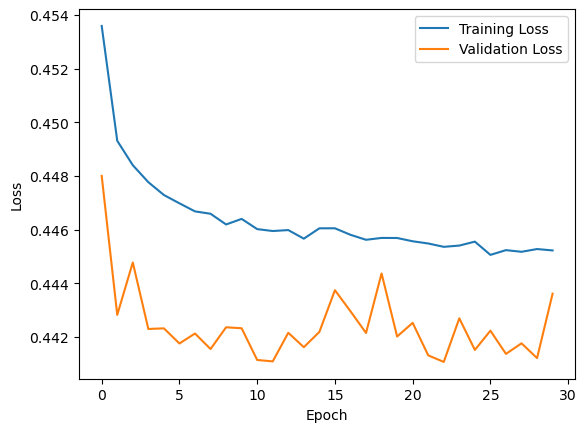

In [14]:
# Plot training and validation losses
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


    

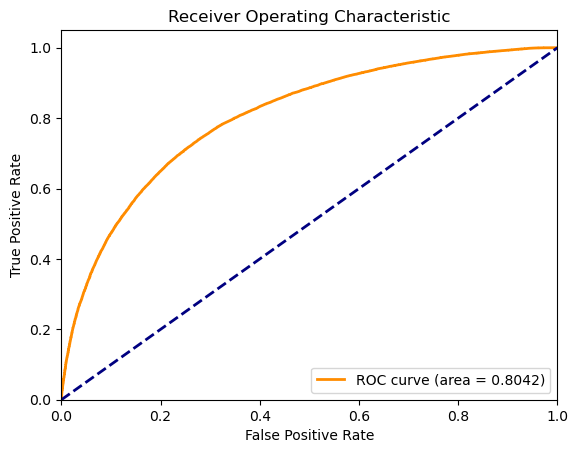

In [15]:
from sklearn.metrics import roc_curve, auc

# Evaluate the model on the test set
model.eval()
y_test_pred = []
with torch.no_grad():
    for batch_x, _, _, _ in test_loader:
        outputs = model(batch_x)
        y_test_pred.append(outputs)

# Concatenate all predictions
y_test_pred = torch.cat(y_test_pred).cpu().numpy()
y_test_true = y_test.cpu().numpy()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Plot Histograms For Model Output

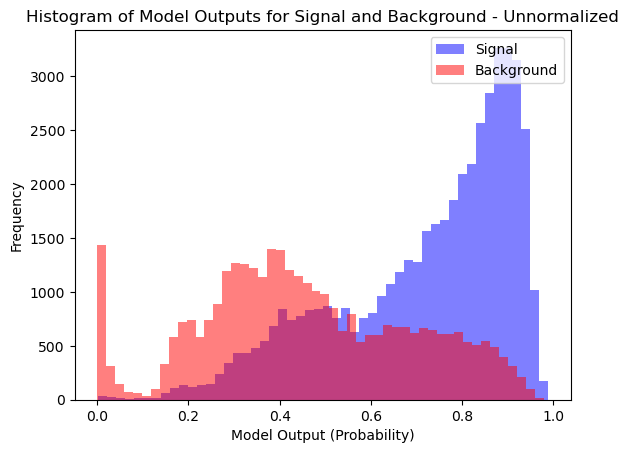

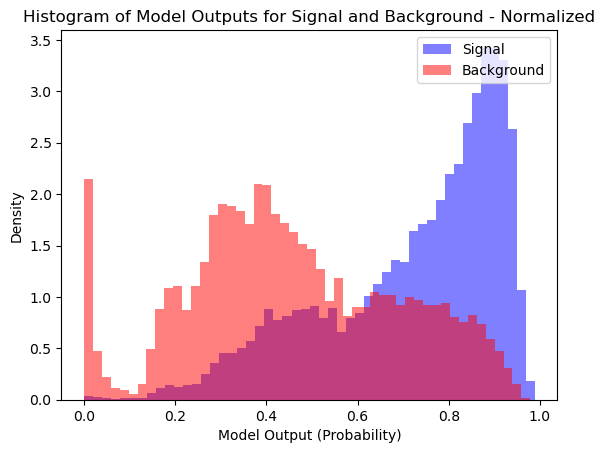

In [16]:
# Apply sigmoid function to model outputs to get probabilities
signal_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 1])).numpy()
background_probs = torch.sigmoid(torch.tensor(y_test_pred[y_test_true == 0])).numpy()

# Plot histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue')
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red')
plt.xlabel('Model Output (Probability)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Unnormalized')
plt.show()

# Plot normalized histograms
plt.hist(signal_probs, bins=50, alpha=0.5, label='Signal', color='blue', density=True)
plt.hist(background_probs, bins=50, alpha=0.5, label='Background', color='red', density=True)
plt.xlabel('Model Output (Probability)')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.title('Histogram of Model Outputs for Signal and Background - Normalized')
plt.show()

## Flatten by including jets
### mlp needs same input per event. zero padding to just give zeros. Start by giving just first few jets.

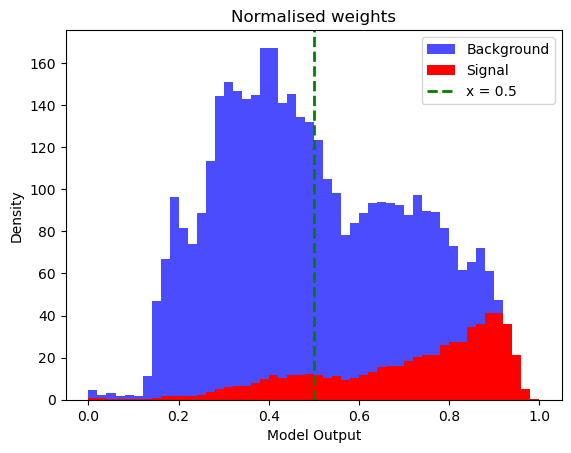

In [17]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



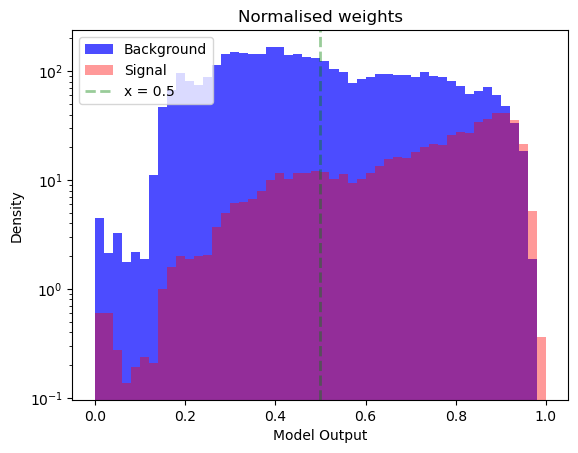

In [18]:
#reread


# Evaluate model on test set with normalised weights
model.eval()

# Lists to store model outputs and labels
all_outputs = []
all_labels = []

# Iterate over test data
with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # outputs = model(batch_x) applies the model to the input batch to generate model outputs.
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        #sigmoid function is applied to the model outputs to convert them to probabilities.
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility

        #all_outputs and all_labels are lists that store the model outputs and target labels for the test set.
        #.extend() appends the model outputs and target labels for each batch to the lists.
        all_outputs.extend(probs)

        #batch_y is the target labels for the batch. .numpy() converts the tensor to a numpy array.
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels).flatten() # Flatten to a 1D array

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r', alpha=0.4)
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5',alpha=0.4)
plt.xlabel('Model Output')
plt.yscale('log')

plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()



Instead of Z = S/sqrt(B),

Z = s/sqrt(B + sigma_b^2)  
where B is the background, S is the signal, and sigma_b is the uncertainty in the background.

Curve may peak in different place and curve will generally go down.

/tmp/ipykernel_3364020/28217656.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wn_test_array = np.array(wn_test*200000)


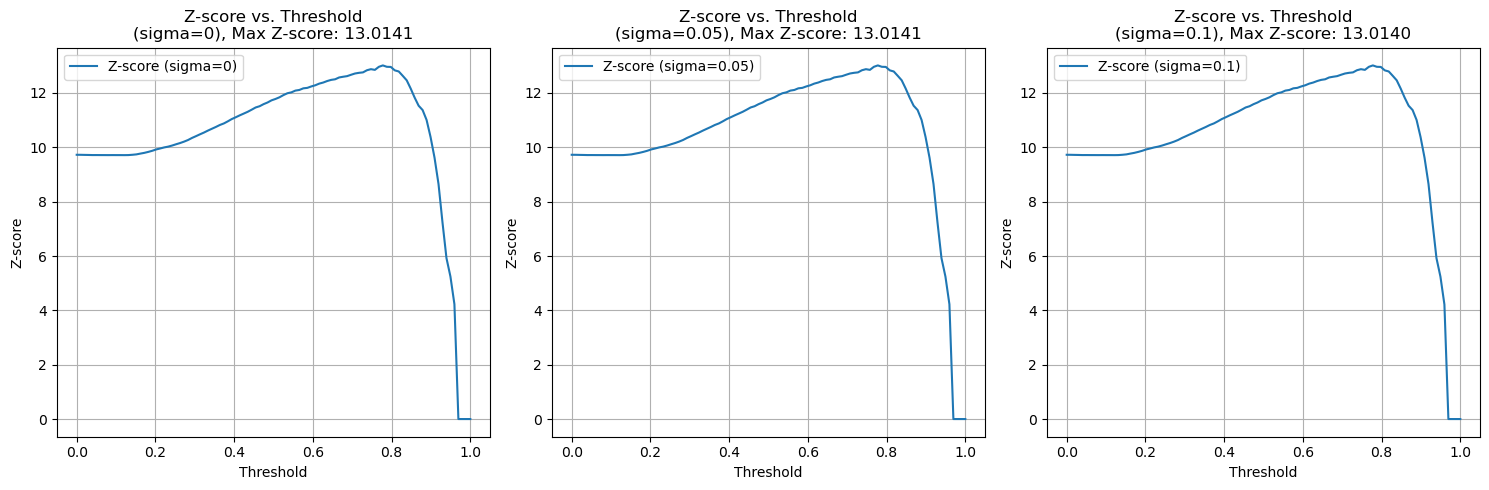

In [19]:
#define uncertainty
sigma_values = [0,0.05,0.1]

# Assume wn_test is the array of weights for each sample in the test set 
wn_test_array = np.array(wn_test*200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 100)
fig, axes = plt.subplots(1, len(sigma_values), figsize=(15, 5))





# Calculate the Z-score for each threshold using weights

for i, sigma in enumerate(sigma_values):
    z_scores = []
    for threshold in thresholds:
        # Weighted count of signal predictions above the threshold
        S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
        B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background

        # Calculate Z-score (add small epsilon to avoid division by zero)
        if S > 2:
            Z = S / np.sqrt(B + sigma**2 +1e-10)  # 1e-10 to avoid division by zero
        else:
            Z = 0  # Define Z as 0 if S + B is 0
        z_scores.append(Z)

    # Plot Z-score vs. Threshold for the current sigma
    axes[i].plot(thresholds, z_scores, label=f"Z-score (sigma={sigma})")
    axes[i].set_xlabel("Threshold")
    axes[i].set_ylabel("Z-score")
    axes[i].set_title(f"Z-score vs. Threshold\n(sigma={sigma}), Max Z-score: {max(z_scores):.4f}")
    axes[i].legend()
    axes[i].grid()


plt.tight_layout()
plt.show()

In [20]:
# Extract the Z-scores within the specified range
z_scores = np.array(z_scores)

# Find the maximum Z-score and its index within the specified range
max_z_index = np.argmax(z_scores)
max_z = z_scores[max_z_index]

# Find the corresponding threshold
threshold_at_max_z = thresholds[max_z_index]

#calculate associated S and B values at threshold of max z score
S_at_max_z = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 1)])  # Weighted Signal
B_at_max_z = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 0)])  # Weighted Background

# Calculate the associated S and B values
S = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 1)])  # Weighted Signal
B = np.sum(wn_test_array[(all_outputs > threshold_at_max_z) & (all_labels == 0)])  # Weighted Background

print(f"Maximum Z-score: {max_z:.4f}")
print(f"Associated S value: {S_at_max_z:.4f}")
print(f"Associated B value: {B_at_max_z:.4f}")

Maximum Z-score: 13.0140
Associated S value: 298.4281
Associated B value: 525.8384


In [21]:
print(len(wn_test_array))

82271


3 curves of different sigma_b on same canvas, making assumptions for size of syst. uncertainty affects Z cut point.

# Parquet Data - TTbar to Semi-leptonic